Copyright (c) Microsoft Corporation. All rights reserved. 

Licensed under the MIT License.

# AutoML with FLAML Library


## 1. Introduction

FLAML is a Python library (https://github.com/microsoft/FLAML) designed to automatically produce accurate machine learning models 
with low computational cost. It is fast and economical. The simple and lightweight design makes it easy to use and extend, such as adding new learners. FLAML can 
- serve as an economical AutoML engine,
- be used as a fast hyperparameter tuning tool, or 
- be embedded in self-tuning software that requires low latency & resource in repetitive
   tuning tasks.

In this notebook, we use one real data example (binary classification) to showcase how to use FLAML library.

FLAML requires `Python>=3.7`. To run this notebook example, please install flaml with the `notebook` option:
```bash
pip install flaml[notebook]
```

In [ ]:
%pip install flaml[notebook]
# from v0.6.6, catboost is made an optional dependency to build conda package.
# to install catboost without installing the notebook option, you can run:
# %pip install flaml[catboost]

## 2. Classification Example
### Load data and preprocess

Download [Airlines dataset](https://www.openml.org/d/1169) from OpenML. The task is to predict whether a given flight will be delayed, given the information of the scheduled departure.

In [2]:
from flaml.data import load_openml_dataset
X_train, X_test, y_train, y_test = load_openml_dataset(dataset_id=1169, data_dir='/mnt/data/automl-domino')

load dataset from /mnt/data/automl-domino/openml_ds1169.pkl
Dataset name: airlines
X_train.shape: (404537, 7), y_train.shape: (404537,);
X_test.shape: (134846, 7), y_test.shape: (134846,)


### Run FLAML
In the FLAML automl run configuration, users can specify the task type, time budget, error metric, learner list, whether to subsample, resampling strategy type, and so on. All these arguments have default values which will be used if users do not provide them. For example, the default classifiers are `['lgbm', 'xgboost', 'xgb_limitdepth', 'catboost', 'rf', 'extra_tree', 'lrl1']`. 

In [2]:
''' import AutoML class from flaml package '''
from flaml import AutoML
automl = AutoML()

In [3]:
settings = {
    "time_budget": 600,  # total running time in seconds
    "metric": 'accuracy',  # can be: 'r2', 'rmse', 'mae', 'mse', 'accuracy', 'roc_auc', 'roc_auc_ovr',
                           # 'roc_auc_ovo', 'log_loss', 'mape', 'f1', 'ap', 'ndcg', 'micro_f1', 'macro_f1'
    "task": 'classification',  # task type
    "log_file_name": 'airlines_experiment.log',  # flaml log file
    "seed": 7654321,    # random seed
}

In [4]:
'''The main flaml automl API'''
automl.fit(X_train=X_train, y_train=y_train, **settings)

[flaml.automl: 09-22 10:45:40] {2565} INFO - task = classification
[flaml.automl: 09-22 10:45:40] {2567} INFO - Data split method: stratified
[flaml.automl: 09-22 10:45:40] {2570} INFO - Evaluation method: holdout
[flaml.automl: 09-22 10:45:40] {2689} INFO - Minimizing error metric: 1-accuracy
[flaml.automl: 09-22 10:45:40] {2831} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl: 09-22 10:45:40] {3133} INFO - iteration 0, current learner lgbm
[flaml.automl: 09-22 10:45:41] {3266} INFO - Estimated sufficient time budget=13027s. Estimated necessary time budget=320s.
[flaml.automl: 09-22 10:45:41] {3313} INFO -  at 0.6s,	estimator lgbm's best error=0.3777,	best estimator lgbm's best error=0.3777
[flaml.automl: 09-22 10:45:41] {3133} INFO - iteration 1, current learner lgbm
[flaml.automl: 09-22 10:45:41] {3313} INFO -  at 0.7s,	estimator lgbm's best error=0.3777,	best estimator lgbm's best error=0.3777
[fl

### Best model and metric

In [5]:
'''retrieve best config and best learner'''
print('Best ML leaner:', automl.best_estimator)
print('Best hyperparmeter config:', automl.best_config)
print('Best accuracy on validation data: {0:.4g}'.format(1-automl.best_loss))
print('Training duration of best run: {0:.4g} s'.format(automl.best_config_train_time))

Best ML leaner: lgbm
Best hyperparmeter config: {'n_estimators': 157, 'num_leaves': 985, 'min_child_samples': 115, 'learning_rate': 0.15986853540486204, 'log_max_bin': 6, 'colsample_bytree': 0.8905312088154893, 'reg_alpha': 0.17376372850615002, 'reg_lambda': 196.88994398476, 'FLAML_sample_size': 364083}
Best accuracy on validation data: 0.6731
Training duration of best run: 12.89 s


In [6]:
automl.model.estimator

LGBMClassifier(colsample_bytree=0.8905312088154893,
               learning_rate=0.15986853540486204, max_bin=63,
               min_child_samples=115, n_estimators=157, num_leaves=985,
               reg_alpha=0.17376372850615002, reg_lambda=196.88994398476,
               verbose=-1)

In [8]:
import os
os.mkdir('./model')
'''pickle and save the automl object'''
import pickle
with open('./model/automl.pkl', 'wb') as f:
    pickle.dump(automl, f, pickle.HIGHEST_PROTOCOL)
'''load pickled automl object'''
with open('./model/automl.pkl', 'rb') as f:
    automl = pickle.load(f)

In [9]:
'''compute predictions of testing dataset''' 
y_pred = automl.predict(X_test)
print('Predicted labels', y_pred)
print('True labels', y_test)
y_pred_proba = automl.predict_proba(X_test)[:,1]

Predicted labels ['1' '0' '1' ... '1' '0' '0']
True labels 118331    0
328182    0
335454    0
520591    1
344651    0
         ..
367080    0
203510    1
254894    0
296512    1
362444    0
Name: Delay, Length: 134846, dtype: category
Categories (2, object): ['0' < '1']


In [10]:
''' compute different metric values on testing dataset'''
from flaml.ml import sklearn_metric_loss_score
print('accuracy', '=', 1 - sklearn_metric_loss_score('accuracy', y_pred, y_test))
print('roc_auc', '=', 1 - sklearn_metric_loss_score('roc_auc', y_pred_proba, y_test))
print('log_loss', '=', sklearn_metric_loss_score('log_loss', y_pred_proba, y_test))

accuracy = 0.6716550731946072
roc_auc = 0.7261168808693911
log_loss = 0.6028861723506801


See Section 4 for an accuracy comparison with default LightGBM and XGBoost.

### Log history

In [11]:
from flaml.data import get_output_from_log
time_history, best_valid_loss_history, valid_loss_history, config_history, metric_history = \
    get_output_from_log(filename=settings['log_file_name'], time_budget=240)
for config in config_history:
    print(config)

{'Current Learner': 'lgbm', 'Current Sample': 10000, 'Current Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 4, 'num_leaves': 4, 'min_child_samples': 20, 'learning_rate': 0.09999999999999995, 'log_max_bin': 8, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'FLAML_sample_size': 10000}}
{'Current Learner': 'lgbm', 'Current Sample': 10000, 'Current Hyper-parameters': {'n_estimators': 26, 'num_leaves': 4, 'min_child_samples': 18, 'learning_rate': 0.22930096764186372, 'log_max_bin': 9, 'colsample_bytree': 0.9086551727646448, 'reg_alpha': 0.0015561782752413472, 'reg_lambda': 0.33127416269768944, 'FLAML_sample_size': 10000}, 'Best Learner': 'lgbm', 'Best Hyper-parameters': {'n_estimators': 26, 'num_leaves': 4, 'min_ch

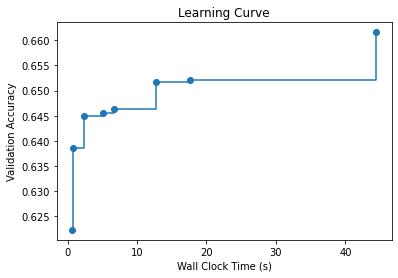

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.title('Learning Curve')
plt.xlabel('Wall Clock Time (s)')
plt.ylabel('Validation Accuracy')
plt.scatter(time_history, 1 - np.array(valid_loss_history))
plt.step(time_history, 1 - np.array(best_valid_loss_history), where='post')
plt.savefig('./learningcurve.png')
plt.show()